In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm import tqdm

from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error as mae

from itertools import product

In [2]:
def get_stats(a, b):
    r, p = pearsonr(a, b)
    error = mae(a, b)
    return r, error

In [51]:
res_fp = Path('data/res_ds_iter.nc')

if res_fp.exists():
    res_ds = xr.load_dataset(res_fp)

else:
    param_fp = Path('/bsuhome/zacharykeskinen/scratch/param_regional')

    locs = list(param_fp.glob('*'))
    locs = [l.stem for l in locs]
    # Create parameter space
    A = np.round(np.arange(1, 3.1, 0.5), 2)
    B = np.round(np.arange(0, 1.01, 0.1), 2)
    C = np.round(np.arange(0.01, 1.001, 0.01), 2)
    iterations = np.arange(100)
    res = np.zeros((len(locs), len(A), len(B), len(C), len(iterations)))


    da = xr.DataArray(res, coords = [locs, A, B, C, iterations], dims = ['location', 'A', 'B','C', 'iteration'], name = 'pearsonr')
    res_ds = xr.merge([da, da.rename('mae')])

    for loc_fp in param_fp.glob('*'):
        print(loc_fp)
        lidar = np.load(loc_fp.joinpath('lidar.npy'))
        for a, b, c in product(A, B, C):
            sds = np.load(loc_fp.joinpath(f'{a}_{b}_{c}.npy'))
            combo = np.vstack([lidar, sds])
            for iter in iterations:
                idx = np.random.choice(combo.shape[1], combo.shape[1], replace = True)
                sds, lidar = combo.T[idx].T
                r, mean_error = get_stats(lidar, sds)
                res_ds['pearsonr'].loc[dict(location = loc_fp.stem, A = a, B = b, C = c, iteration = iter)] = r
                res_ds['mae'].loc[dict(location = loc_fp.stem, A = a, B = b, C = c, iteration = iter)] = mean_error
    res_ds.to_netcdf(res_fp)

/bsuhome/zacharykeskinen/scratch/param_regional/Mores_2021-03-15


KeyboardInterrupt: 

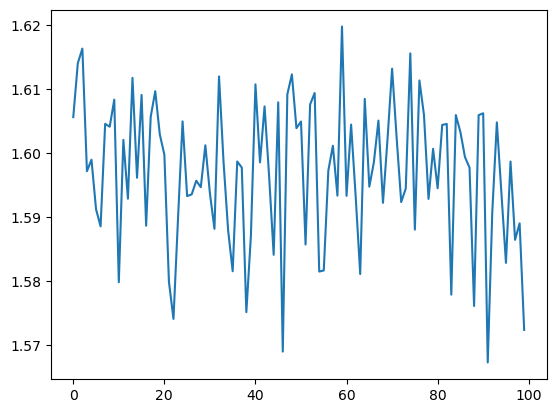

In [58]:
plt.plot(res_ds.sel(location = 'Mores_2021-03-15', A = 1, B = 0, C = 0.01)['mae'])

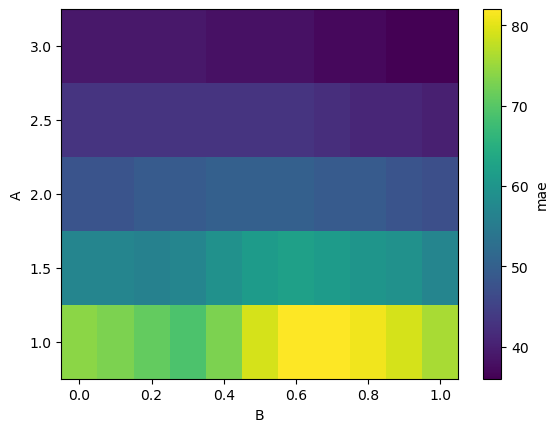

In [7]:
res_ds.std(dim ='location')['mae'].argmin(dim = 'C').plot()

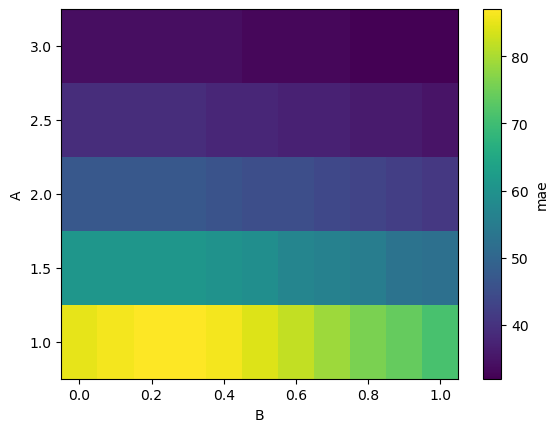

In [86]:
res_ds.mean(dim ='location')['mae'].argmin(dim = 'C').plot()

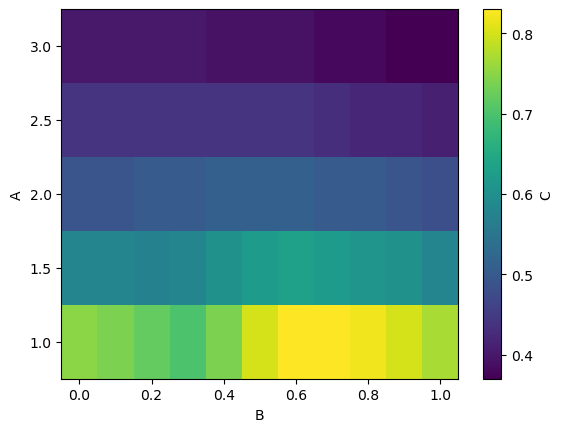

In [87]:
res_ds.mean(dim ='location')['mae'].idxmin(dim = 'C').plot()